# Preparation and loading steps

In [73]:
import numpy as np
import pandas as pd 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy.stats import entropy
#from tqdm.notebook import tqdm, trange
from tqdm import tqdm, trange
import statsmodels.api as sm
import statistics 
from scipy.stats import gaussian_kde
import seaborn as sns 

In [2]:
# Connecting drive in google collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loadig prebuilt arrays to save time
toy_triplets = np.load("/content/drive/My Drive/MSc Statistics/toy_triplets.npy")
total_playcount = np.load("/content/drive/My Drive/MSc Statistics/total_playcount.npy")
gini_index = np.load("/content/drive/My Drive/MSc Statistics/gini_index.npy")
hill_no = np.load("/content/drive/My Drive/MSc Statistics/hill_no.npy")
distinct_songs = np.load("/content/drive/My Drive/MSc Statistics/distinct_songs.npy")
distinct_artists = np.load("/content/drive/My Drive/MSc Statistics/distinct_artists.npy")
shannon = np.load("/content/drive/My Drive/MSc Statistics/shannon.npy")
pop_score = np.load("/content/drive/My Drive/MSc Statistics/pop_score_10.npy")
pop_score_5 = np.load("/content/drive/My Drive/MSc Statistics/pop_score.npy")
relative = np.load("/content/drive/My Drive/MSc Statistics/relative.npy")

In [10]:
toy_triplets = np.load("toy_triplets.npy", allow_pickle=True)

In [11]:
toy_triplets = pd.DataFrame(toy_triplets, columns = ["UserId", "SongId", "Count", "TrackId", "Artist", "Song"])

In [19]:
toy_triplets["Count"] = toy_triplets["Count"].astype(float)

In [108]:
!pip install lowess

  Using cached https://files.pythonhosted.org/packages/5d/24/91ad2da4a1da2747595d2f47f858a131036f598fb495ec6346d08d8b8df6/pandas-1.0.5-cp37-cp37m-macosx_10_9_x86_64.whl
  Created wheel for lowess: filename=lowess-1.0.2-cp37-none-any.whl size=6114 sha256=ce35b0c56e252eaac51dddfec8391318ac57d0cdbaec7d3f1b73908c3052c5fb
  Stored in directory: /Users/MacBook_Retina_2015_256Gb/Library/Caches/pip/wheels/32/45/c2/e70ca4ad60fb118d193cae63ca7a83bb5a443c1eba58e46672
Successfully built lowess
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.6.0, but you'll have ipykernel 5.3.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement notebook~=5.2.0, but you'll have notebook 5.7.9 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=0.24.0, but you'll have pandas 1.0.5 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but y

# Functions used further

In [66]:
def plot(p,q, xlab, ylab, filename, frac=0.2):
  # Plots scatterplot with mass gradient and LOwESS
  # p - x variable
  # q - y variable

  # stacking data for the density gradient
  xy = np.vstack([p,q])
  # calling 
  z = gaussian_kde(xy)(xy)

  idx = z.argsort()
  x, y, z = p[idx], q[idx], z[idx]

  df = pd.DataFrame({'x': p, 'Raw': q})
  df["pred"] = lo.lowess(df["Raw"], df["x"], frac, 2)

  sorted_index = np.argsort(df["Raw"])
  X_sort = df["Raw"][sorted_index]
  y_sort = df["0.2"][sorted_index]  

  fig, ax = plt.subplots()
  # main scatter
  ax.scatter(df["Raw"], df["x"], c=z, s=50, edgecolor='', cmap=plt.cm.summer)
  # LOWESS 
  ax.plot(X_sort, y_sort, "r", label="LOWESS")
  leg = ax.legend(loc=7)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(filename, format = "png", transparent = True)
  plt.show()

In [ ]:
def plot_hill(p,q, xlab, ylab, filename):
  # Plots scatterplot with mass gradient and dummy line of best fit
  # p - x variable
  # q - y variable
  xy = np.vstack([p,q])
  z = gaussian_kde(xy)(xy)

  idx = z.argsort()
  x, y, z = p[idx], q[idx], z[idx]

  m, b = np.polyfit(p, q, 1)

  fig, ax = plt.subplots()
  ax.scatter(x, y, c=z, s=50, edgecolor='', cmap=plt.cm.summer)
  ax.plot(p, m*p + b, label="OLS", color="r")
  leg = ax.legend(loc=1)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(filename, format = "png", transparent = True)
  plt.show()

# Loading all data and analysis

Loading all datasets used - main triplet data, embedded vectors generates with Poisson factotization, bridge data that connects TrackId with SongId and song genre data. 

In [ ]:
# main triplet data
data = pd.read_csv("/content/drive/My Drive/MSc Statistics/train_triplets.txt",
                   delimiter="\t", header=None, names= ["UserId", "SongId", "Count"])

In [ ]:
print(len(data["UserId"].unique().tolist()), len(data["SongId"].unique().tolist()))

1019318 384546


In [ ]:
data.shape

(48373586, 3)

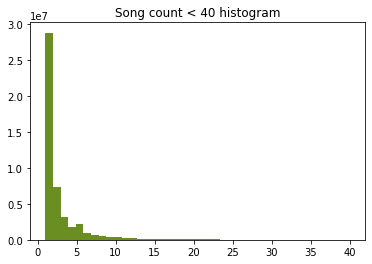

In [ ]:
plt.hist(data["Count"][data["Count"]<=40], bins = 40, color = "olivedrab", density=False)
plt.title("Song count < 40 histogram")
plt.savefig("count_hist", format = "png", transparent = True)

In [ ]:
data.describe()

,Count
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.667000e+03


In [ ]:
np.sum(data["Count"]>1000)

62

## Analysing duplicate SongId issue

In [ ]:
# data to connect TrackId with SongId
bridge = pd.read_csv("/content/drive/My Drive/MSc Statistics/unique_tracks.txt",  delimiter="<SEP>", header=None, 
                    names= ["TrackId", "SongId", "Artist", "Song_name"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
bridge[bridge["Artist"]=='Oasis And Friends Inc Johnny Depp']

,TrackId,SongId,Artist,Song_name
466076,TRNGLYC12903CD1E0E,SOWZYNH12AB0184007,Oasis And Friends Inc Johnny Depp,Fade Away


In [ ]:
bridge[bridge["SongId"]=="SOWZYNH12AB0184007"]

,TrackId,SongId,Artist,Song_name
276209,TRFCSVT128F9350484,SOWZYNH12AB0184007,Oasis,Fade Away
466076,TRNGLYC12903CD1E0E,SOWZYNH12AB0184007,Oasis And Friends Inc Johnny Depp,Fade Away


In [ ]:
bridge.describe()

,TrackId,SongId,Artist,Song_name
count,1000000,1000000,1000000,999985
unique,1000000,999056,72665,702000
top,TRLPROK128F9310D6A,SOZBJBH12A8151BD4E,Michael Jackson,Intro
freq,1,3,194,1511


In [ ]:
artists_1 = bridge["Artist"].unique().tolist()

In [ ]:
a = bridge.groupby(["SongId"]).size().to_frame()
a.columns = ["Count"]

In [ ]:
a.sort_values(by = ["Count"], ascending=False)

,Count
SongId,
SOUYQYY12AF72A000F,3
SOLNCTS12A8C1405EF,3
SOQNMCD12A8C1383D4,3
SOBPAEP12A58A77F49,3
SOVASUH12A67021B44,3
...,...
SOHXMHZ12A5891FFDF,1
SOHXMIP12AAF3B3C24,1
SOHXMJG12AB0182DA9,1


In [ ]:
bridge[bridge["SongId"]=="SOUYQYY12AF72A000F"]

,TrackId,SongId,Artist,Song_name
270307,TRFMXXY128F932E381,SOUYQYY12AF72A000F,Franz Ferdinand,Dream Again
745578,TRSZVBU128F92F5956,SOUYQYY12AF72A000F,Franz Ferdinand,Dream Again
841287,TRDOZYK128F931128F,SOUYQYY12AF72A000F,Franz Ferdinand,Dream Again


In [ ]:
bridge[bridge["SongId"]=="SOLNCTS12A8C1405EF"]

,TrackId,SongId,Artist,Song_name
64210,TRWEFJA128F42BB94C,SOLNCTS12A8C1405EF,Aerosmith,Pink
533504,TRPOMZK128F42BB712,SOLNCTS12A8C1405EF,Aerosmith,Pink
835731,TRDJJBQ12903C9FFB1,SOLNCTS12A8C1405EF,Aerosmith,Pink


In [ ]:
# dropping duplicte values 
bridge.drop_duplicates(subset = "SongId", inplace=True) 

In [ ]:
bridge.describe()

,TrackId,SongId,Artist,Song_name
count,999056,999056,999056,999041
unique,999056,999056,72652,701922
top,TRETPYA128F92F0E38,SOAYLWW12AB017AEA8,Johnny Cash,Intro
freq,1,1,191,1511


In [ ]:
artists_2 = bridge["Artist"].unique().tolist()

In [ ]:
set(artists_1)-set(artists_2)

{'Chris Farlow',
 'D.J.Generous',
 'Jermaine Dupri featuring Jay-Z',
 'Lilly Allen',
 'Lito y Manolo - The Gypsies',
 'Meck ft. Dino',
 'Oasis And Friends Inc Johnny Depp',
 'Paola Dipietromaria',
 'RUN-DMC Featuring Method Man_ Kenny Cash_ Mike Ransom_ and Jamel Simmons',
 'Richard Hawley And Death Ramps_ Arctic Monkeys',
 'Shakira ft. Wyclef Jean',
 'Tineke Schouten/Linda De Mol/Franklin Brown',
 'Tony Marshall'}

# Merging the data

Merging the data so we could connect SongId with some metadata. Conducting the same data analysis below.

In [ ]:
artist_merge = pd.merge(left = data, right = bridge, left_on="SongId", right_on="SongId")

In [ ]:
artist_merge.head()

,UserId,SongId,Count,TrackId,Artist,Song_name
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
1,7c86176941718984fed11b7c0674ff04c029b480,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
2,76235885b32c4e8c82760c340dc54f9b608d7d7e,SOAKIMP12A8C130995,3,TRIQAUQ128F42435AD,Jack Johnson,The Cove
3,250c0fa2a77bc6695046e7c47882ecd85c42d748,SOAKIMP12A8C130995,1,TRIQAUQ128F42435AD,Jack Johnson,The Cove
4,3f73f44560e822344b0fb7c6b463869743eb9860,SOAKIMP12A8C130995,6,TRIQAUQ128F42435AD,Jack Johnson,The Cove


In [ ]:
print(artist_merge.shape)

(49664528, 6)


In [ ]:
print(len(artist_merge["SongId"].unique().tolist()), len(artist_merge["TrackId"].unique().tolist()))

384546 384546


# Subsampling triplets

Creating a 1000 user subsample of dataset to aid with computational speed.

In [ ]:
toy_triplets = pd.DataFrame(artist_merge['UserId'].unique(), columns=["UserId"]).sample(n=10000, random_state=123)

In [ ]:
toy_triplets

,UserId
892790,6922083dbcd4cdb8d1d85c3d63fcedeafc9bddc2
962264,9a4a0fd94d767a8f96aaaa5332ff441b3f060cd5
948679,21c310f8a98769736f6e82d6f2cd6fd83d88391d
243789,e13b56d6997fcafa2967a79f9709bd75c2307172
681051,5540dd4a1b6ec2642ee4c586b3c35d4c73cdcb6c
...,...
837073,96631a3b420a9edc9a6e0206a43d56004959d63a
376891,61d9bbadabbeabaf83b42a42d6b798ce72afe890
811666,560e1adfc9dcb10b15891de06e7ea47165b929a2
872959,1edb610583a7fa07ef64475d6e3d7ff473a2f937


In [ ]:
toy_triplets = pd.merge(left = toy_triplets, right = artist_merge, left_on="UserId", right_on="UserId")

In [ ]:
del artist_merge

In [14]:
print("Number of unique users:", len(toy_triplets["UserId"].unique().tolist()), ",",
"Number of unique songs:", len(toy_triplets["SongId"].unique().tolist()),
   "Number of unique tracks:",  len(toy_triplets["TrackId"].unique().tolist()))

Number of unique users: 10000 , Number of unique songs: 105296 Number of unique tracks: 105296


In [27]:
toy_triplets["Count"].astype(float).describe()

count    472358.000000
mean          2.889618
std           6.558600
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1222.000000
Name: Count, dtype: float64

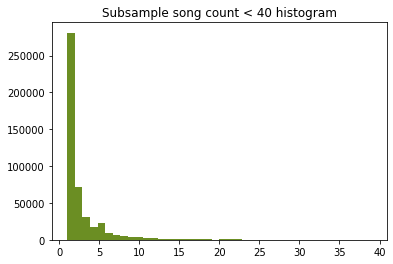

In [25]:
plt.hist(toy_triplets["Count"][toy_triplets["Count"]<40], bins = 40,
         color = "olivedrab", density = False)
plt.title("Subsample song count < 40 histogram")
plt.savefig("count_hist_2", format = "png", transparent = True)

In [20]:
sum_art = toy_triplets.groupby(["Artist"]).size()

In [22]:
sum_art[:10]

Artist
!!!                             25
& And Oceans                     2
'68 Comeback                     2
'N Sync/Phil Collins            13
'Til Tuesday                     6
't Hof Van Commerce & Brahim     1
(Love) Tattoo                    1
(hed) p.e.                       7
*NSYNC featuring Nelly           1
*Shels                           1
dtype: int64

#Entropy implementation

## Shannon Entropy


In [ ]:
def entropy_me(p):
    c = []
    for i in p:
        if i == 0:
            b = 0
        else:
            b = -i*math.log2(i)
        c.append(b)
    d = sum(c)
    return d

In [28]:
# getting a list of unique UserIds
users = toy_triplets["UserId"].unique().tolist()

# calculating the Shannon entropy for each user separatelly and stacking
# everything into the list "shannon"
shannon = []
for i in tqdm(users):
  b = toy_triplets["Count"][toy_triplets["UserId"]==i]/(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
  #a = entropy_me(b)
  a = entropy(b, base = 2)
  shannon.append(a)

100%|██████████| 10000/10000 [08:35<00:00, 19.39it/s]


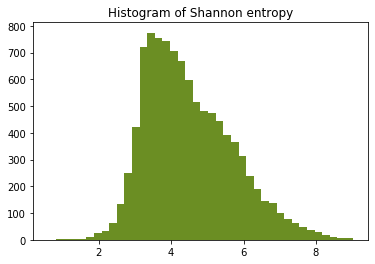

In [30]:
# histograms
plt.hist(shannon, bins=40, color="olivedrab", density=False)
plt.title("Histogram of Shannon entropy")
plt.savefig("shannon_hist", format = "png", transparent = True)

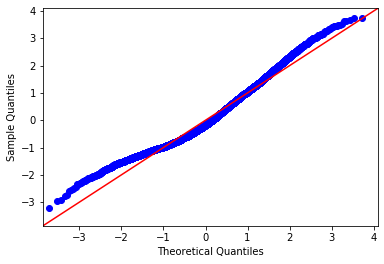

In [32]:
fig = sm.qqplot(np.array(shannon), fit=True, line='45')
plt.show()

In [33]:
pd.DataFrame(shannon).describe()

,0
count,10000.000000
mean,4.494901
std,1.204890
min,0.608996
25%,3.572624
50%,4.292790
75%,5.285238
max,9.012254


In [34]:
np.save("shannon", shannon)

Interesting bell-shapped distribution with right skew around the median. Overall, a nice spread of entropies - might indicate that it manages to separate even close cases.

### Further vizualisations



We will examine the relationship between the Shannon entropy score and total playcount, coverage (number of distinct songs, artist) and popularity.

In [36]:
# total playcount
total_playcount = []
for i in tqdm(users):
  total_playcount.append(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
# np.save("total_playcount", total_playcount)

100%|██████████| 10000/10000 [04:25<00:00, 37.61it/s]


In [37]:
np.save("total_playcount", total_playcount)

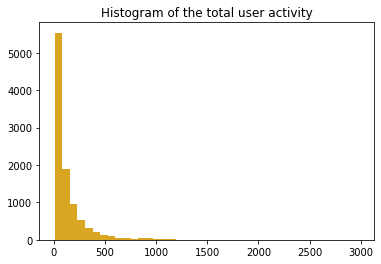

In [38]:
plt.hist(total_playcount, bins = 40, color = "goldenrod")
plt.title("Histogram of the total user activity")
plt.savefig("total_play_hist", format = "png", transparent = True)

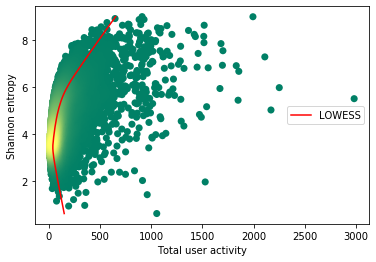

In [85]:
plot(np.array(total_playcount), np.array(shannon),
     "Total user activity", "Shannon entropy", "tot_play_shannon", frac = 0.4)

In [76]:
# song coverage
distinct_songs = toy_triplets.groupby(["UserId"]).size()
distinct_songs = pd.merge(left = pd.DataFrame(users, columns = ["UserId"]), right = distinct_songs.to_frame(),
                            left_on = "UserId", right_on = distinct_songs.to_frame().index)

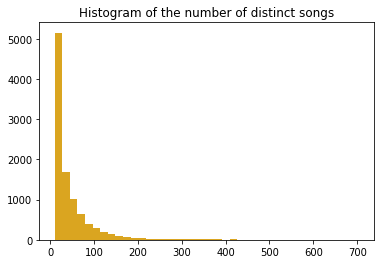

In [59]:
plt.hist(distinct_songs[0], bins = 40, color = "goldenrod")
plt.title("Histogram of the number of distinct songs")
plt.savefig("dist_song_hist", format = "png", transparent = True)

No handles with labels found to put in legend.


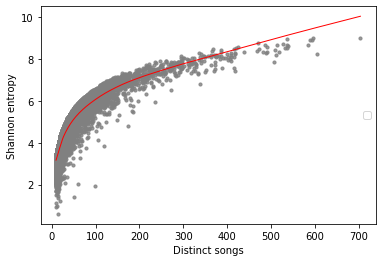

In [77]:
plot_2(np.array(distinct_songs[0]), np.array(shannon),
     "Distinct songs", "Shannon entropy", "dist_songs_shannon")

In [61]:
distinct_songs.describe()

count    10000.00000
mean        47.23580
std         57.87497
min         10.00000
25%         16.00000
50%         27.00000
75%         55.00000
max        704.00000
dtype: float64

In [62]:
np.save("distinct_songs", distinct_songs)

In [64]:
# artist coverage
distinct_artists = []
for i in tqdm(users):
  a = len(toy_triplets["Artist"][toy_triplets["UserId"]==i].unique().tolist())
  distinct_artists.append(a)
np.save("distinct_artists", distinct_artists) 

100%|██████████| 10000/10000 [04:25<00:00, 37.68it/s]


In [63]:
pd.DataFrame(distinct_artists).describe()

NameError: name 'distinct_artists' is not defined

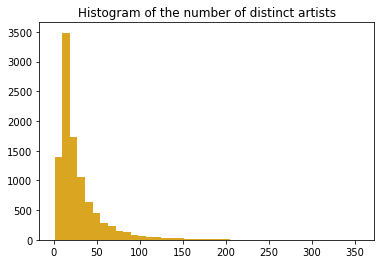

In [ ]:
plt.hist(distinct_artists, bins = 40, color = "goldenrod")
plt.title("Histogram of the number of distinct artists")
plt.savefig("dist_art_hist", format = "png", transparent = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


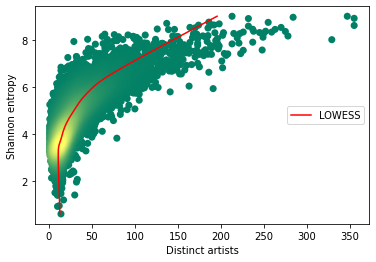

In [ ]:
plot(distinct_artists, shannon, "Distinct artists", "Shannon entropy", "dist_art_shannon")

In [ ]:
# popularity measure - refer to notes.
# Consructing a synthetic user who listens only to the song which at least 10%
# of the population listened to at least once


# getting Q - a user who listens only to popular songs

# getting a list of unique SongId

# define q^1 - each instance of song being played at least onces corresponds to
# a one count in q^1
sum_song = toy_triplets.groupby(["SongId"]).size()
sum_song = sum_song.to_frame()
sum_song["SongId"] = sum_song.index
sum_song.columns = ["Count_q", "SongId"]
sum_song.index.names = ["Index"]

In [ ]:
Q_max = sum_song.sort_values(by = "Count_q", ascending=False)[:500]

In [ ]:
pop_score = []
for i in tqdm(users):
  b = []
  a = toy_triplets["SongId"][toy_triplets["UserId"]==i].values
  for j in Q_max["SongId"]:
    if j in a:
      b.append(1)
    else:
      b.append(0)
  pop_score.append(np.sum(b))   

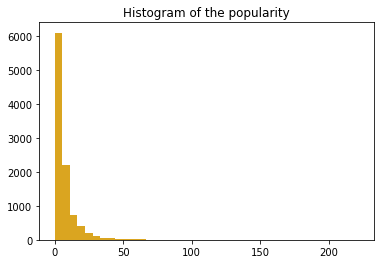

In [ ]:
plt.hist(pop_score_5, bins = 40, color = "goldenrod")
plt.title("Histogram of the popularity")
plt.savefig("pop_hist", format = "png", transparent = True)

In [ ]:
pd.DataFrame(pop_score_5).describe()

,0
count,10000.000000
mean,7.133000
std,11.881036
min,0.000000
25%,1.000000
50%,4.000000
75%,9.000000
max,222.000000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


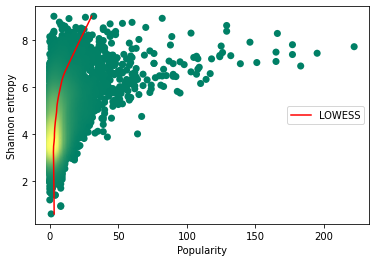

In [ ]:
plot(pop_score_5, shannon, "Popularity", "Shannon entropy", "pop_shannon")

## Kulback-Leibler divergence

In [ ]:
# Kullback-Leibner divergence function
# Must use it since the inbuilt "entrpy" command normalizes q by default
def KL(p,q):
    c = []
    for i, j in zip(p,q):
        if i == 0:
            b = 0
        else:
            b = i*math.log2(i/j)
        c.append(b)
    d = sum(c)
    return d

In [ ]:
# getting q_j as probability
Q_joint = sum_song
Q_joint["Count_q"] = Q_joint["Count_q"]/np.sum(Q_joint["Count_q"])

In [ ]:
# list users from above (Shannon entropy)
relative = []
for u in tqdm(users):
  # subset the Count and SongID data for each user
  p = toy_triplets[toy_triplets["UserId"] == u]
  # merge with Q so that the absent songs would disappear (p_ij = 0 contributes
  # 0 to KL, hence it is equivalent to discard it a priori)
  mid = pd.merge(left = p, right = Q_joint, left_on = "SongId", 
                 right_on = "SongId")
  # defining a p_ij variable as a percentage 
  a = mid["Count"]/np.sum(mid["Count"])
  # KL function aggregate
  relative.append(KL(a, mid["Count_q"]))

In [ ]:
np.save("relative", relative)

In [ ]:
pd.DataFrame(relative).describe()

,0
count,10000.000000
mean,10.341420
std,1.829547
min,3.459969
25%,9.097697
50%,10.341204
75%,11.604322
max,17.216453


Text(0.5, 1.0, 'Histogram of the relative entropy')

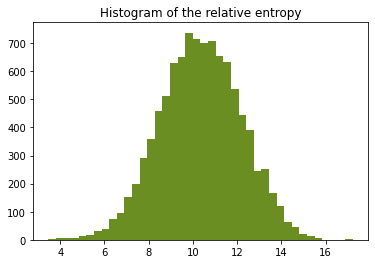

In [ ]:
plt.hist(relative, bins=40, color = "olivedrab", density=False)
plt.title("Histogram of the relative entropy")
#plt.savefig("relative_hist", format = "png", transparent = True)

Similar shape as Shannon entropy. Nice spread too. Now checking the correlation

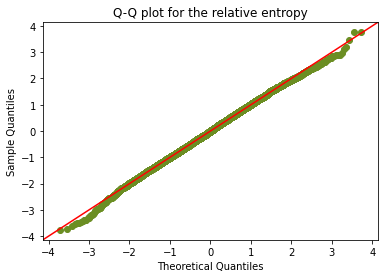

In [ ]:
# QQ plot to assess normality
fig = sm.qqplot(relative, fit=True, line='45', color = "olivedrab")
plt.title("Q-Q plot for the relative entropy")
plt.savefig("QQ", format = "png", transparent = True)
plt.show()

In [ ]:
# CI
low = np.mean(relative) - 1.96*np.std(relative)
high = np.mean(relative) + 1.96*np.std(relative)

### Further vizualisations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


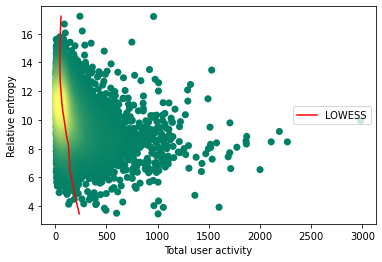

In [ ]:
plot(total_playcount, relative, "Total user activity", "Relative entropy", "tot_play_relative")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


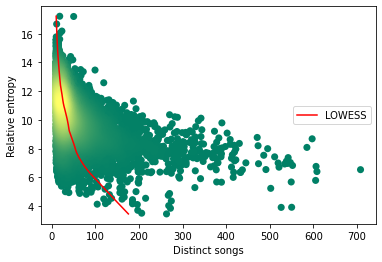

In [ ]:
plot(distinct_songs, relative, "Distinct songs", "Relative entropy", "dist_song_relative")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


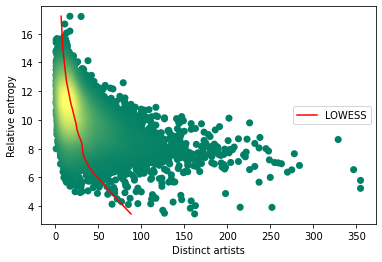

In [ ]:
plot(distinct_artists, relative, "Distinct artists", "Relative entropy", "dist_art_relative")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


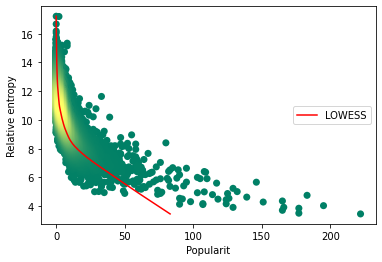

In [ ]:
plot(pop_score_5, relative, "Popularit", "Relative entropy", "pop_relative")

Strong positive correlation as expected. There is some tendency for the users to have relativelly higher KL divergence score than the Shannon entropy score meaning that some users might be seen more mainstream generalist than they are seen generalist

## Gini-index


In [ ]:
# Gini function
def gini(p):
    c = []
    for i in p:
        b = i**2
        c.append(b)
    d = 1 - sum(c)    
    return d

In [ ]:
# getting gini index for each user independently
gini_index = []
for i in tqdm(users):
  b = toy_triplets["Count"][toy_triplets["UserId"]==i]/(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
  a = gini(b)
  gini_index.append(a)

In [ ]:
pd.DataFrame(gini_index).describe()

,0
count,10000.000000
mean,0.922579
std,0.063915
min,0.138345
25%,0.898438
50%,0.936703
75%,0.966555
max,0.997696


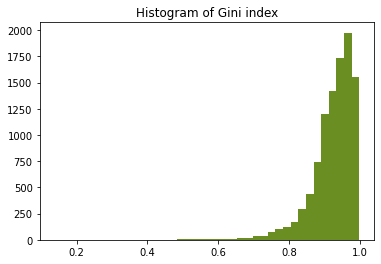

In [ ]:
plt.hist(gini_index, bins = 40, density = False, color="olivedrab")
plt.title("Histogram of Gini index")
plt.savefig("gini_hist", format = "png", transparent = True)

In [ ]:
gini_max = pd.DataFrame(gini_index, columns= ["Score"]).sort_values(by = "Score" ,
                                                                    ascending=False)[:8000]

In [ ]:
pd.DataFrame(gini_index, columns= ["Score"]).describe()

,Score
count,10000.000000
mean,0.922579
std,0.063915
min,0.138345
25%,0.898438
50%,0.936703
75%,0.966555
max,0.997696


Most of the values are large - inbetween 0.9 and 1 indicating that according to Gini index, most of the users are rather generalist - the probability of two random draws with replacement to be different is large. The data spread is limited and that is an issue. I suppose this is due to the very small probabilities $p_{ij}$.

### Further vizualisations

Relationship between the Gini index and the KL divergence is very similar to the one between Gini and Shannon entropy with more noise added due to the different benchmark measurement of the KL divergence.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


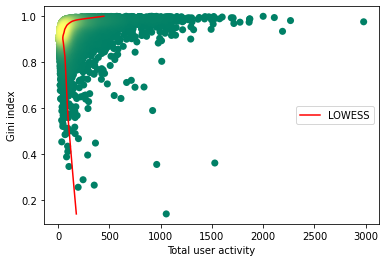

In [ ]:
plot(total_playcount, gini_index, "Total user activity", "Gini index", "tot_play_gini")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


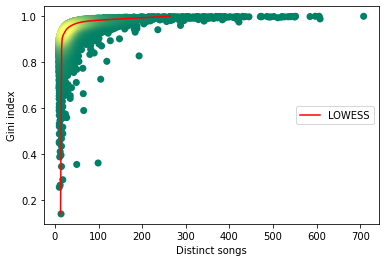

In [ ]:
plot(distinct_songs, gini_index, "Distinct songs", "Gini index", "dist_song_gini")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


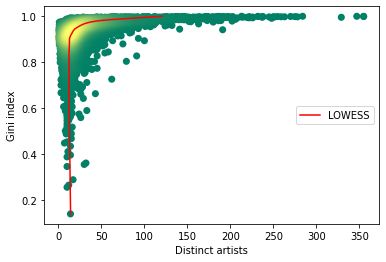

In [ ]:
plot(distinct_artists, gini_index, "Distinct artists", "Gini index", "dist_art_gini")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


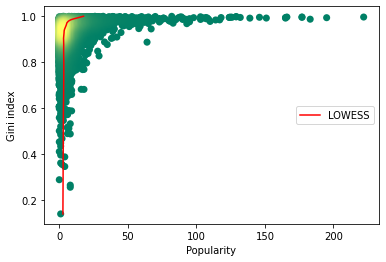

In [ ]:
plot(pop_score_5, gini_index, "Popularity", "Gini index", "pop_gini")

## Hill number


In [ ]:
# Hill number function
def hill(p,q):
    c =[]
    for i in p:
        b = i**q
        c.append(b)
    d = sum(c)**(1/(1-q))   
    return d

In [ ]:
# implementation for each user and then aggregating in list "hill_no"
hill_no = []
for i in users:
  b = toy_triplets["Count"][toy_triplets["UserId"]==i]/(np.sum(toy_triplets["Count"][toy_triplets["UserId"]==i]))
  a = hill(b,3)
  hill_no.append(a)

In [ ]:
np.save("hill_no", hill_no)

In [ ]:
pd.DataFrame(hill_no).describe()

,0
count,10000.000000
mean,21.373273
std,24.527541
min,1.118795
25%,8.418490
50%,13.492956
75%,24.574552
max,362.329328


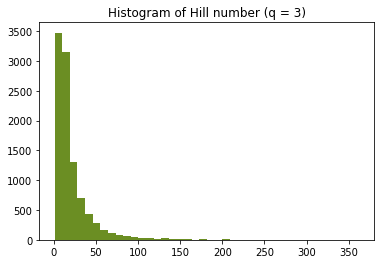

In [ ]:
plt.hist(hill_no, bins = 40, color = "olivedrab", density = False)
plt.title("Histogram of Hill number (q = 3)")
plt.savefig("hill_hist", format = "png", transparent = True)

There is somewhat more spread than with the Gini index with most of the Hill values ranging from 2 to just bellow 200 categories indicating that it would be easier to define a threashold for the specialist/ generialist labeling.

### Further vizualisations

Now we have positive quadratic convex relationship. The data spread is clearly better than with Gini index. The correlation with the Shannon entropy is, however smaller. It seems that users with large entropy values tend to require fewer equifrequent songs that one would expect under the linear relationship case. 

Extremelly low correlation between Hill number and Gini index and a rather non-sensial scatter plots indicates that these two measures are rather different and capture different aspect of the data.

The relationship between the Hill number and KL divergence is rather similar to the one between the former and the Shannon entropy, yet with more noise potentialy arising due to the KL divergence measuring similarity to the mainstream generalist as opposed to the overall generalist

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


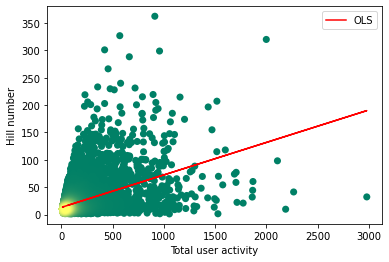

In [ ]:
plot_hill(total_playcount, hill_no, "Total user activity", "Hill number", "tot_play_hill")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


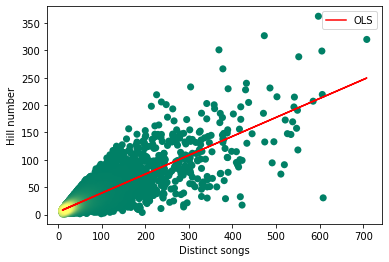

In [ ]:
plot_hill(distinct_songs, hill_no, "Distinct songs", "Hill number", "dist_song_hill")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


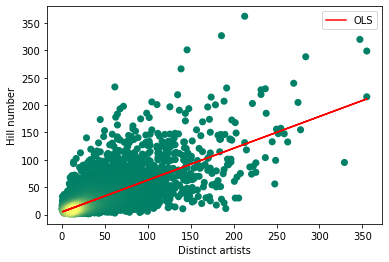

In [ ]:
plot_hill(distinct_artists, hill_no, "Distinct artists", "Hill number", "dist_art_hill")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


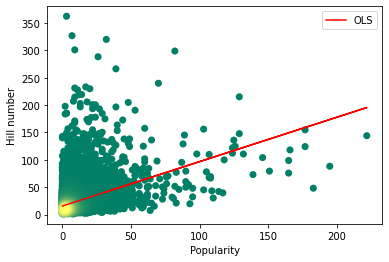

In [ ]:
plot_hill(pop_score_5, hill_no, "Popularity", "Hill number", "pop_hill")

# Entropy concordance

## Shannon and relative

(-0.5461298327633929, 0.0)


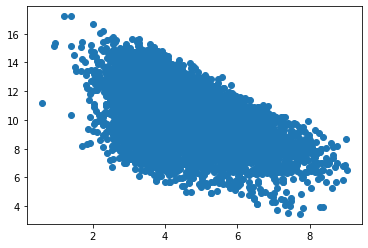

In [ ]:
plt.scatter(shannon, relative)
print(pearsonr(shannon, relative))

In [ ]:
toy_with_pop = pd.merge(left = toy_artist_merge, right = Q_id, right_on = "SongId", left_on = "SongId")

In [ ]:
import scipy.stats as stats

tau, p_value = stats.kendalltau(shannon, relative)

In [ ]:
print(tau, p_value)

-0.371156806655047 0.0


In [ ]:
shannon_r = stats.rankdata(shannon, method="min")
relative_r = stats.rankdata(relative, method="max")

In [ ]:
relative_r

array([9203, 4228, 9863, ..., 8351, 8892,  210])

In [ ]:
relative

array([12.92348568,  9.96988803, 14.18802797, ..., 12.14100258,
       12.59664659,  6.62427483])

In [ ]:
shannon_r

array([1729, 2172, 2404, ...,  742,  291, 7805])

In [ ]:
shannon

array([3.40398945, 3.52164064, 3.58418372, ..., 3.06688965, 2.74408552,
       5.47313288])

In [ ]:
a = shannon_r-relative_r

(array([ 75., 120., 158., 168., 203., 229., 237., 242., 249., 269., 280.,
        281., 307., 318., 311., 328., 278., 339., 320., 319., 340., 298.,
        303., 301., 295., 326., 291., 286., 284., 268., 272., 251., 225.,
        214., 206., 202., 180., 177., 152.,  98.]),
 array([-9996. , -9496.8, -8997.6, -8498.4, -7999.2, -7500. , -7000.8,
        -6501.6, -6002.4, -5503.2, -5004. , -4504.8, -4005.6, -3506.4,
        -3007.2, -2508. , -2008.8, -1509.6, -1010.4,  -511.2,   -12. ,
          487.2,   986.4,  1485.6,  1984.8,  2484. ,  2983.2,  3482.4,
         3981.6,  4480.8,  4980. ,  5479.2,  5978.4,  6477.6,  6976.8,
         7476. ,  7975.2,  8474.4,  8973.6,  9472.8,  9972. ]),
 <a list of 40 Patch objects>)

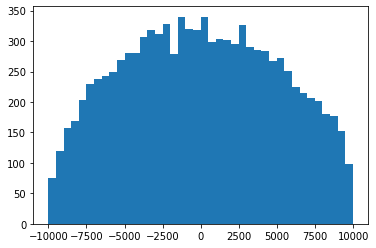

In [ ]:
plt.hist(a, bins = 40)

{'boxes': [<matplotlib.lines.Line2D at 0x7f293d6e5080>],
 'caps': [<matplotlib.lines.Line2D at 0x7f293d6e5a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f293d6f1550>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f293d6f11d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f293d6e5390>,
  <matplotlib.lines.Line2D at 0x7f293d6e5710>]}

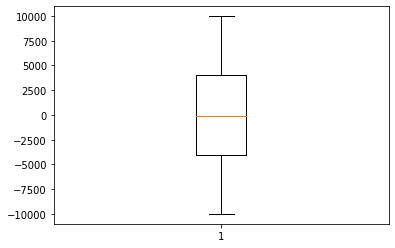

In [ ]:
plt.boxplot(a)

In [ ]:
pd.DataFrame(a).describe()

,0
count,10000.000000
mean,-1.073100
std,5040.835239
min,-9996.000000
25%,-4027.250000
50%,-67.500000
75%,4026.750000
max,9972.000000


In [ ]:
# check where values are more than 10
np.where(a == 17)

(array([28]),)

In [ ]:
toy_with_pop[toy_with_pop["UserId"] == users[28]]

,UserId,SongId,Count,TrackId,Artist,Song_name,Freq_q
836,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOQTPLM12B0B809575,1,TRAJNLN128F427D137,The Black Keys,Strange Times,3
983,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOTEPSZ12AB018C99D,1,TRKSEEY12903CCD312,The Black Keys,Ten Cent Pistol,3
3320,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOXGXKY12A8C13A405,2,TRRJFXX128F427A71F,The Black Keys,Remember When (Side A),2
3532,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOITRTA12A6D4F8261,7,TRDRTNQ128F93313A3,Metallica,Ride The Lightning,3
4718,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOMRTUH12AB0185650,1,TRSVTRT12903CB450E,The Black Keys,The Lengths,2
...,...,...,...,...,...,...,...
7408,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOYKZMF12A8C132C30,1,TRIFTWF128F426ADD7,John Denver,Eagles And Horses,1
7409,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOYXSUQ12A8C13BC13,1,TRGOZHU128F427F9A5,Mariana Aydar,Maior É Deus,1
7410,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOZKXKH12A8C131FFB,1,TRIMNTB128F424E2C2,Ultraje A Rigor,Nós Vamos Invadir Sua Praia,1
7411,ac006af6edb9b4b5345b8c268c3d205bc1b15001,SOZODMP12AB018061F,12,TROQOJH128F92EFDD4,Major Lazer / Mr. Lex / Santigold,Hold The Line,2


In [ ]:
print(shannon_r[28], relative_r[28], 
      shannon[28], relative[28])

59 42 6.481286056696259 -7.356461018722857


In [ ]:
print(total_playcount[28], distinct_songs[28], distinct_artists[28], pop_score[28])

373 129 68 0


,0
count,100.000000
mean,343.080000
std,364.844195
min,16.000000
25%,110.750000
50%,225.000000
75%,436.000000
max,2409.000000


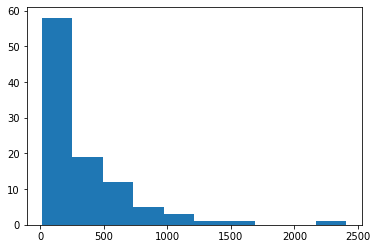

In [ ]:
plt.hist(total_playcount)
pd.DataFrame(total_playcount).describe()

,0
count,100.000000
mean,160.550000
std,201.392846
min,10.000000
25%,53.250000
50%,104.500000
75%,173.750000
max,1267.000000


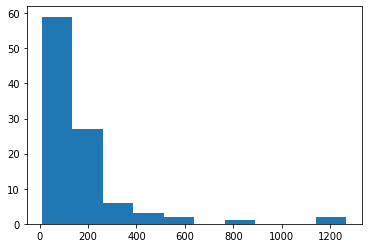

In [ ]:
plt.hist(distinct_songs)
pd.DataFrame(distinct_songs).describe()

,0
count,100.000000
mean,81.100000
std,81.199654
min,4.000000
25%,28.750000
50%,57.500000
75%,102.250000
max,434.000000


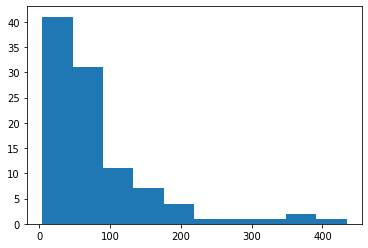

In [ ]:
plt.hist(distinct_artists)
pd.DataFrame(distinct_artists).describe()

,0
count,100.000000
mean,3.410000
std,5.759656
min,0.000000
25%,0.000000
50%,1.000000
75%,3.250000
max,23.000000


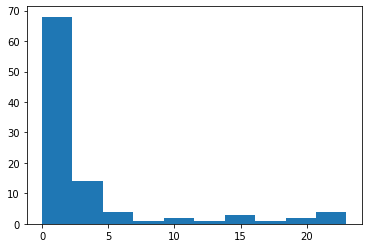

In [ ]:
plt.hist(pop_score)
pd.DataFrame(pop_score).describe()

In [ ]:
# check where values are more than 10
np.where(a == -47)

(array([57]),)

In [ ]:
print(shannon_r[57], relative_r[57], 
      shannon[57], relative[57])

39 86 5.801164626079563 -5.404896860761347


In [ ]:
print(total_playcount[57], distinct_songs[57], distinct_artists[57], pop_score[57])

167 76 61 22


So Shannon vs KL divergence is pure popularity difference.

## Shannon - Hill number

In [ ]:
hill_no_r = stats.rankdata(hill_no, method = "min")

In [ ]:
tau, p_value = stats.kendalltau(shannon_r, hill_no_r)

In [ ]:
print(tau, p_value)

0.7712817144198877 0.0


In [ ]:
diff_b = np.array(shannon_r)-np.array(hill_no_r) 

(array([1389., 2530., 3741., 1306.,  597.,  259.,  110.,   49.,   14.,
           5.]),
 array([-2009. , -1157.1,  -305.2,   546.7,  1398.6,  2250.5,  3102.4,
         3954.3,  4806.2,  5658.1,  6510. ]),
 <a list of 10 Patch objects>)

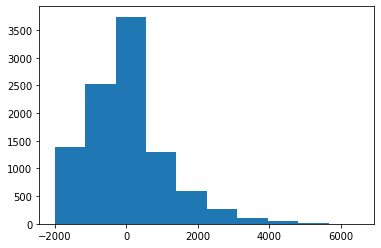

In [ ]:
plt.hist(diff_b)

In [ ]:
pd.DataFrame(diff_b).describe()

,0
count,100.000000
mean,0.000000
std,6.928203
min,-15.000000
25%,-4.000000
50%,-0.500000
75%,3.000000
max,21.000000


In [ ]:
print(np.where(diff_b == 21), np.where(diff_b==-15))

(array([55]),) (array([32]),)


In [ ]:
print(shannon_r[21], hill_no_r[21], 
      shannon[21], hill_no[21])

64 41 6.641596465690961 33.890953891150104


In [ ]:
print(total_playcount[55], distinct_songs[55], distinct_artists[55], pop_score[55])

448 209 154 0


In [ ]:
toy_artist_merge[toy_artist_merge["UserId"]==users[55]]

,UserId,SongId,Count,TrackId,Artist,Song_name
1397,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOTUYFC12A8C13AE26,1,TRTAEKL128F92F8DB8,Noosa Head Feat. Marshall Jefferson,Mushrooms
3155,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOSJDQJ12A8C13D4A9,1,TRABOVH128F427D3B4,Chromeo,Fancy Footwork
3299,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOWRTJD12A8C132704,1,TRXIOUQ128F4269099,Aerosmith,Dream On
3341,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZVCRW12A67ADA0B7,1,TRNTALF128EF343800,The Killers,When You Were Young
3460,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOFFQBG12A6D4F9793,2,TREIHZT128F146E229,Juanes,La Camisa Negra
...,...,...,...,...,...,...
10973,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZJEAW12A58A761DB,5,TRRAXZJ128F92F56A8,Wilson Pickett,Land Of 1000 Dances
10974,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZNBUK12A8C1383E3,1,TRMSIRD128F427EEFD,Sufjan Stevens,Sleeping Bear_ Sault Saint Marie
10975,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZNMYQ12A6D4F837E,2,TRNGMZZ128F1469CFE,Wagon Christ,Piano Playa Hata
10976,9d633fa5e6c1e6c4304d3394a1c1802d04e9d5e2,SOZSNXB12A6310E141,1,TRQACSU128F1460103,Bentley Rhythm Ace,Jim'll Twist It


(array([150.,  25.,  10.,   6.,   6.,   2.,   4.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.   ,  1.925,  2.85 ,  3.775,  4.7  ,  5.625,  6.55 ,  7.475,
         8.4  ,  9.325, 10.25 , 11.175, 12.1  , 13.025, 13.95 , 14.875,
        15.8  , 16.725, 17.65 , 18.575, 19.5  , 20.425, 21.35 , 22.275,
        23.2  , 24.125, 25.05 , 25.975, 26.9  , 27.825, 28.75 , 29.675,
        30.6  , 31.525, 32.45 , 33.375, 34.3  , 35.225, 36.15 , 37.075,
        38.   ]),
 <a list of 40 Patch objects>)

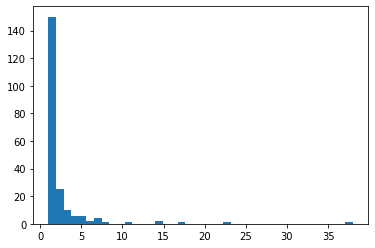

In [ ]:
plt.hist(toy_artist_merge["Count"][toy_artist_merge["UserId"]==users[55]], bins = 40)

Ranking difference among those who have large count songs.  This is because frequent songs contribute only very small number to the Hill's number. This means that user 55, who according his behaviour should be listened as a strong generalist due to her playcount, number of artist and song stemming from classic rock to electornic and classical music is labelled as specialist because he has a few songs with relativelly high counts. Maybe we should do Hill q = 2? Hill CAN put more emphasis on more abundand categories. This might be useful. When changed to q = 2, the disconcordance decreased (Kendel's Tau rose to 0.86), yet the two most extreme values remained the same - 55 and 32.


## Shannon - Gini 

In [ ]:
gini_r = stats.rankdata(gini_index, method="min")
tau, p_val = stats.kendalltau(relative, gini_r)
print(tau, p_value)

-0.35257693255351846 0.0


,0
count,100.000000
mean,0.000000
std,6.928203
min,-15.000000
25%,-4.000000
50%,-0.500000
75%,3.000000
max,21.000000


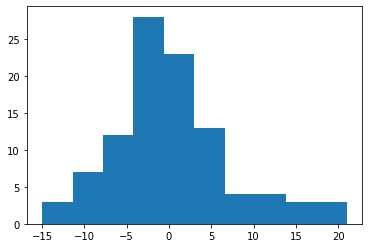

In [ ]:
diff_c = np.array(shannon_r) - np.array(gini_r)
plt.hist(diff_c)
pd.DataFrame(diff_c).describe()

In [ ]:
print(np.where(diff_c==21), np.where(diff_c==-15))
# same as Hill vs Shannon

(array([55]),) (array([32]),)


In [ ]:
print(shannon_r[55], gini_r[55], 
      shannon[55], gini_index[55])

70 49 6.873332756614353 0.9816047512755102


# Specific users

In [ ]:
# say user 10, 145, 608, 402, 809
users = toy_triplets["UserId"].unique().tolist()

In [ ]:
shannon = np.load("/content/drive/My Drive/MSc Statistics/shannon.npy",)

In [ ]:
print(shannon[10], shannon[145], shannon[608], shannon[402], shannon[809])

4.208014407423748 3.584962500721157 4.819292498749399 5.362814332565778 4.029111629418335


In [ ]:
toy_triplets[toy_triplets["UserId"]==users[10]]

,UserId,SongId,Count,TrackId,Artist,Song_name
300,79840501d4919dd130c87dd6239f16bd6322cbbf,SOAQMNM12AB0188D7A,2,TRHBLDA12903CC32E9,Lifehouse,You And Me (Wedding Version)
301,79840501d4919dd130c87dd6239f16bd6322cbbf,SOUAUCI12A6D4FB7EE,1,TRPPOUP128F421C344,Maná,Dejame entrar (En vivo )
302,79840501d4919dd130c87dd6239f16bd6322cbbf,SODETVE12A6D4FD30E,3,TRERQDA128F421C7FA,Rosario,Algo Contigo
303,79840501d4919dd130c87dd6239f16bd6322cbbf,SOMLHWH12A8C139E74,1,TRDDWYA128F4291A31,Rosario,Búscame
304,79840501d4919dd130c87dd6239f16bd6322cbbf,SOTKSQH12A58A7C520,2,TRCOCZC128F42AEE50,Niña Pastori,Cuando Nadie Me Ve
305,79840501d4919dd130c87dd6239f16bd6322cbbf,SOGPBDO12A6D4F7F85,1,TRNFCDV128F1489886,Creedence Clearwater Revival,Who'll Stop The Rain
306,79840501d4919dd130c87dd6239f16bd6322cbbf,SOQSKQA12A8C143597,1,TRSBHCG128F92FB4DE,Bacilos,Nada
307,79840501d4919dd130c87dd6239f16bd6322cbbf,SOJSXAN12A6D4FBDC7,1,TRSEURU128F423BB62,Rosana,El talisman
308,79840501d4919dd130c87dd6239f16bd6322cbbf,SOTOKLW12A8AE46748,1,TRSHPLD128F423BB6A,Rosana,Asi son las cosas
309,79840501d4919dd130c87dd6239f16bd6322cbbf,SOXUCDD12A8AE46733,2,TRLCNWM128F423BB63,Rosana,A fuego lento


In [ ]:
toy_triplets[toy_triplets["UserId"]==users[145]]

,UserId,SongId,Count,TrackId,Artist,Song_name
6829,1262299bbc5d8cf83e23fef060e99f8522988d41,SOTSIQG12A6D4F46DF,1,TRECHTA128F1462190,Los Prisioneros,Nunca Quedas Mal Con Nadie
6830,1262299bbc5d8cf83e23fef060e99f8522988d41,SOIROVG12AF72A5221,1,TRHOTFY128F429CF52,Los Prisioneros,La Voz De Los '80
6831,1262299bbc5d8cf83e23fef060e99f8522988d41,SOOBUXN12AB01887FA,1,TRIARKQ128F145F173,Orishas,A Lo Cubano
6832,1262299bbc5d8cf83e23fef060e99f8522988d41,SONJILQ12A67020456,1,TRYZVGG128F146D706,Red Hot Chili Peppers,Californication (Album Version)
6833,1262299bbc5d8cf83e23fef060e99f8522988d41,SOZITSW12A6D4FB173,1,TRKBQUZ128F424D7F9,Orishas,Nací Orishas
6834,1262299bbc5d8cf83e23fef060e99f8522988d41,SOWHFDO12A81C232BD,1,TRCRFLR128F422D98D,Geri Halliwell,Mi Chico Latino
6835,1262299bbc5d8cf83e23fef060e99f8522988d41,SOZOHRP12A8C13F9BC,1,TRJACBA128F4290645,Marc Anthony,Te Conozco Bien
6836,1262299bbc5d8cf83e23fef060e99f8522988d41,SOBIHCZ12A6D4F8549,1,TRNCVWT128F1460CC4,Los Prisioneros,We Are Sudamerican Rockers (vivo)
6837,1262299bbc5d8cf83e23fef060e99f8522988d41,SOHPSRR12A8C13D60F,1,TRNTCJN128F42A6DFF,Molotov,Voto Latino
6838,1262299bbc5d8cf83e23fef060e99f8522988d41,SOGDJPO12A8C13C1F9,1,TRZMCLU128F42A51EC,Matisyahu,King Without A Crown


In [ ]:
toy_triplets[toy_triplets["UserId"]==users[608]]

,UserId,SongId,Count,TrackId,Artist,Song_name
27647,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOURYDB12A8C135A6A,1,TRBTCYJ128F92F9586,M83,Teen Angst
27648,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOCUQMK12A8C135B78,1,TRAQYWF128F4260468,The Breeders,Cannonball
27649,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOCGMXY12A6701E069,1,TRHQENS128E0784814,Sting,When We Dance
27650,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOATSLL12AB017B862,2,TRRVXCG128F42AFB36,Mew,The Zookeeper's Boy
27651,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOOEDPF12A6D4F6FBB,2,TROWUZD128F1465363,Black Rebel Motorcycle Club,Too Real
27652,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOECJYO12AB017F15D,3,TRCLJGP128E079273D,Sting,Roxanne
27653,442a00a6719fc8aeaf7d3959ec311f80713a174c,SONEOPP12AB018531E,2,TRICGAH12903CACDDA,Cocteau Twins,Blind Dumb Deaf
27654,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOSBMRU12A8AE474FA,2,TRASYKK128F4259836,My Bloody Valentine,Blown A Wish
27655,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOOKJWB12A6D4FD4F8,3,TRAJXKC128F933E29A,Asobi Seksu,Thursday
27656,442a00a6719fc8aeaf7d3959ec311f80713a174c,SOEMOGY12AF72A7F01,2,TRLYGIY128EF35F64E,Cocteau Twins,Lorelei


In [ ]:
toy_triplets[toy_triplets["UserId"]==users[402]]

,UserId,SongId,Count,TrackId,Artist,Song_name
17896,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOIRRMU12A6D4FB0C0,1,TRPPOCZ128F4282479,Shinedown,Cry For Help (Album Version)
17897,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOUVUHC12A67020E3B,5,TRCQXMT128E0786397,Moby,Lift Me Up
17898,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOXKGUD12A58A7C687,1,TRLDSHP128F148A8A8,Moby,Why Does My Heart Feel So Bad? (2006 Digital R...
17899,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SONQKTW12A8AE46254,2,TRCPTSD128F422B627,Pendulum,The Other Side (album version)
17900,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOQMAIQ12A8AE48EA5,1,TRWXDQP128F42393DB,Pendulum,Granite [Dillinja remix]
17901,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOTNVRG12A8AE46240,1,TRCBKYX128F422B622,Pendulum,Showdown (album version)
17902,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOZLCMW12AB017E35C,1,TRHWSAO128F932BDD6,Tricky,Baligaga
17903,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOQOSMU12A8C138957,1,TRDTVGI128E078EDBB,Queens Of The Stone Age,Go With The Flow
17904,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SONBFPD12A8C14043B,2,TROGRSB128F428123B,The Offspring,Genocide
17905,139c664b59d80e52de7a264bf7a1c1f5fa14be4e,SOXUWRR12A6D4FC42D,1,TRIUZYM128F4222715,Social Distortion,Reach For The Sky (Album)


In [ ]:
toy_triplets[toy_triplets["UserId"]==users[809]]

,UserId,SongId,Count,TrackId,Artist,Song_name
36834,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOAUFOF12AB0180C65,2,TRSFZUW128F42506D2,The White Stripes,Seven Nation Army
36835,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOAUFOF12AB0180C65,2,TRVUNHF128F9303DF4,The White Stripes,Seven Nation Army (Album Version)
36836,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOKIORP12A6D4F5917,1,TREAYDQ128F147CC6C,Metallica,Until It Sleeps
36837,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOCGOZK12A8151BD5D,1,TRBRPFE128F4253C0B,Arctic Monkeys,Fake Tales Of San Francisco (Explicit)
36838,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOCGOZK12A8151BD5D,1,TRASRXK128F9311176,Arctic Monkeys,Fake Tales Of San Francisco
36839,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOUZJMM12A6D4F5911,1,TRWKOEO128F147CC66,Metallica,The God That Failed
36840,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOSNOSA12A67ADA05B,17,TRVEKRD128F148FF1F,Wolfmother,Woman
36841,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOCVOFW12A6D227200,3,TRAJOPN128F423BEC3,Wolfmother,Dimension
36842,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOGNPCC12A58A80B8A,15,TRNERTQ128F146EC6E,Wolfmother,Vagabond
36843,4ae415ab021137ca0e9dc95d6c7cd846abee71b5,SOOFYCT12A6D4F8649,1,TRVWPOG128F93026BA,Wolfmother,Love Train


# Misc


(0.6072273428106829, 0.0)


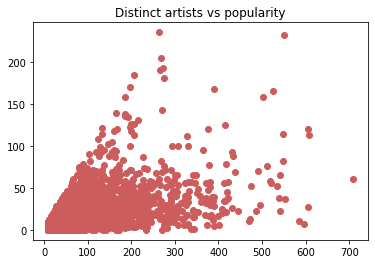

In [ ]:
plt.scatter(distinct_songs, pop_score, color ="indianred")
plt.title("Distinct artists vs popularity")
print(pearsonr(distinct_songs, pop_score))
plt.savefig("dist_pop", format = "png", transparent = True)

In [ ]:
model = sm.OLS(pop_score,distinct_artists)
results = model.fit()
results.params

array([0.31952467])

In [ ]:
results.tvalues

array([111.83348548])

# Evaluation - uniqueness


In [ ]:
print(len(np.unique(shannon))/len(shannon),
      len(np.unique(relative))/len(relative),
      len(np.unique(gini_index))/len(gini_index),
      len(np.unique(hill_no))/len(hill_no))

0.8727 1.0 0.7418 0.8557


In [ ]:
a = [len(np.unique(shannon))/len(shannon),
      len(np.unique(relative))/len(relative),
      len(np.unique(gini_index))/len(gini_index),
      len(np.unique(hill_no))/len(hill_no)]

In [ ]:
a = statistics.mode(gini_index)
np.sum(gini_index == a)

72

In [ ]:
b = pd.DataFrame(gini_index, columns=["gini"]).groupby("gini").size()

In [ ]:
Q_max = sum_song.sort_values(by = "Count_q", ascending=False)[:500]

In [ ]:
len(np.unique(gini_index))

7418

In [ ]:
len(b[b==1])

6534